In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [13]:
from __future__ import print_function
import mxnet as mx
from mxnet import gluon
from mxnet.gluon import nn
from mxnet import autograd as ag
import mxnet.ndarray as F

## Load MNIST dataset

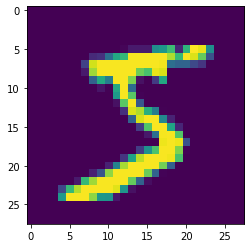

In [9]:
# Fixing the random seed
mx.random.seed(42)

mnist = mx.test_utils.get_mnist()

plt.imshow(np.moveaxis(mnist['train_data'][0], 0, -1))
plt.show()

In [10]:
batch_size = 100
train_data = mx.io.NDArrayIter(mnist['train_data'], mnist['train_label'], batch_size, shuffle=True)
val_data = mx.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)

## Define CNN

In [14]:
class Net(gluon.Block):
    def __init__(self, **kwargs):
        super(Net, self).__init__(**kwargs)
        with self.name_scope():
            # layers created in name_scope will inherit name space
            # from parent layer.
            self.conv1 = nn.Conv2D(20, kernel_size=(5,5))
            self.pool1 = nn.MaxPool2D(pool_size=(2,2), strides = (2,2))
            self.conv2 = nn.Conv2D(50, kernel_size=(5,5))
            self.pool2 = nn.MaxPool2D(pool_size=(2,2), strides = (2,2))
            self.fc1 = nn.Dense(500)
            self.fc2 = nn.Dense(10)

    def forward(self, x):
        x = self.pool1(F.tanh(self.conv1(x)))
        x = self.pool2(F.tanh(self.conv2(x)))
        # 0 means copy over size from corresponding dimension.
        # -1 means infer size from the rest of dimensions.
        x = x.reshape((0, -1))
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x

In [15]:
net = Net()

In [16]:
# set the context on GPU is available otherwise CPU
ctx = [mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()]
net.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.03})

In [19]:
# Use Accuracy as the evaluation metric.
metric = mx.metric.Accuracy()
softmax_cross_entropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()
epoch = 10

for i in range(epoch):
    # Reset the train data iterator.
    train_data.reset()
    # Loop over the train data iterator.
    for batch in train_data:
        # Splits train data into multiple slices along batch_axis
        # and copy each slice into a context.
        data = gluon.utils.split_and_load(batch.data[0], ctx_list=ctx, batch_axis=0)
        # Splits train labels into multiple slices along batch_axis
        # and copy each slice into a context.
        label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
        outputs = []
        # Inside training scope
        with ag.record():
            for x, y in zip(data, label):
                z = net(x)
                # Computes softmax cross entropy loss.
                loss = softmax_cross_entropy_loss(z, y)
                # Backpropogate the error for one iteration.
                loss.backward()
                outputs.append(z)
        # Updates internal evaluation
        metric.update(label, outputs)
        # Make one step of parameter update. Trainer needs to know the
        # batch size of data to normalize the gradient by 1/batch_size.
        trainer.step(batch.data[0].shape[0])
    # Gets the evaluation result.
    name, acc = metric.get()
    # Reset evaluation result to initial state.
    metric.reset()
    print('training acc at epoch %d: %s=%f'%(i, name, acc))

training acc at epoch 0: accuracy=0.867700
training acc at epoch 1: accuracy=0.942400
training acc at epoch 2: accuracy=0.957383
training acc at epoch 3: accuracy=0.965150
training acc at epoch 4: accuracy=0.969567
training acc at epoch 5: accuracy=0.973217
training acc at epoch 6: accuracy=0.975250
training acc at epoch 7: accuracy=0.977633
training acc at epoch 8: accuracy=0.979367
training acc at epoch 9: accuracy=0.980400


In [20]:
x


[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 ...


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0.